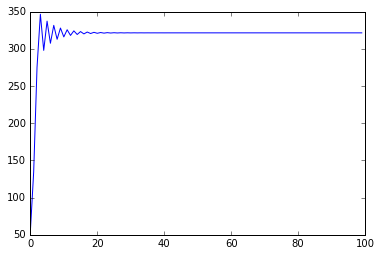

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import random
import time
from collections import defaultdict
%matplotlib inline

class Population(object):
    """ 
    The Population class is used for modeling aggregate-level
    phenomena relevant to the entire population of Person
    instances for a particular simulation run.
    
    """
    
    def __init__(self, people = [], k = 1.0):
        """
        Creates a new Population.
        
        Args:
            people: List. A list of <Person> instances that will
                    comprise the population.
            k: Float. Carrying capacity of the population.
            
        Returns:
            A new Population instance.
            
        """
        
        self.people = people
        self.carrying_capacity = k
        self.death_age_dist = self.init_death_age_dist()
        self.death_age_dist_len = len(self.death_age_dist)-1
        self.death_dict = defaultdict(list)
        if len(self.people) > 0:
            for i in range(len(self.people)):
                self.death_dict[self.people[i].death_age].append(i)
        
    def init_death_age_dist(self, filename='death_age_dist.txt'):
        """
        Creates a distribution for generating random death ages as a list
        based on a death age distribution text file
        Death distribution text file generated from simplified distribution
        from 2007 death age distribution http://www.cdc.gov/nchs/nvss/mortality/gmwk310.htm
        """

        age = 1
        death_age_dist = []
        for line in open(filename):
            death_age_dist.extend([age for i in range(int(line.rstrip('\n')))])
            age += 1

        return death_age_dist

    def get_rand_death_time(self, sim_time):
        """
        Generates a random death age in simulation time based on death 
        age distribution
        """

        return self.death_age_dist[random.randint(0,self.death_age_dist_len)]*12.0 + sim_time

        
    def add_person(self, person):
        """ Adds a new person to the population. """
        
        self.people.append(person)
        self.death_dict[person.death_age].append(self.num_people()-1)
        
        return True

    def remove_person(self, index):
        """ Removes a person from the population given an index. """
        
        del self.people[index]

        return True

    def remove_dead(self, sim_time):
        """ 
        Removes all people from the population whose death age is the 
        given sim time.
        """

        for death_index in reversed(self.death_dict.get(sim_time, [])):
            del self.people[death_index]

        return True
        
    def num_people(self):
        """ Returns the current number of people in the population. """
        
        return (len(self.people))
    
    def kcal_requirements(self, sim_time):
        """ 
        Returns the aggregate monthly kcal requirements for the entire population.
        """
        
        return np.sum([person.kcal_requirements(sim_time) for person in self.people])
    

class Person(object):
    """ 
    The Person class is used for modeling an individual
    human instance in the simulation.
    
    """
    
    def __init__(self, birthday, death_age, gender):
        """
        Creates a new Person.
        
        Args:
            birthday: Integer. Birth moment of the person, in a
                      number of simulation timesteps.
            death_age: Integer. Simulation timestep that the person will die at
            gender: String. Sex of the person: must be one of 'm', 
                    or 'f'.
                       
        Returns:
            A new Person instance.
            
        """
        
        self.birthday = birthday
        self.death_age = death_age
        self.gender = 'f' if gender < 0.5 else 'm'
        
    def current_age(self, sim_time):
        """ 
        Computes the current age of the person in years from the current 
        simulation time (as an integer number of timesteps). Assumes each
        timestep corresponds to one month.
        
        """
        
        return (sim_time - self.birthday) / 12.0
    
    def kcal_requirements(self, sim_time):
        """ 
        Computes the monthly kcal intake requirements for the person. 
        Depends on age and gender.
        
        Returns the number of kcals as an integer.
        
        """
        
        # Find the current age of the person.
        age = self.current_age(sim_time)
        
        # Initialize our kcals.
        kcals = None
        
        if age <= 1:
            kcals = 820
        elif age <= 3:
            kcals = 1350
        elif age <= 5:
            kcals = 1550
        else:
            if self.gender == 'm':
                if age <= 7:
                    kcals = 1850
                elif age <= 10:
                    kcals = 2100
                elif age <= 12:
                    kcals = 2200
                elif age <= 14:
                    kcals = 2400
                elif age <= 16:
                    kcals = 2650
                elif age <= 18:
                    kcals = 2850
                else:
                    kcals = 3050
            elif self.gender == 'f':
                if age <= 7:
                    kcals = 1750
                elif age <= 10:
                    kcals = 1800
                elif age <= 12:
                    kcals = 1950
                elif age <= 14:
                    kcals = 2100
                elif age <= 16:
                    kcals = 2150
                elif age <= 18:
                    kcals = 2150
                else:
                    kcals = 2350
            else:
                raise Exception('Person does not have a gender.')
                
        # Return the number of kcals required.        
        return (kcals * 365) / 12.0

    
class Facility(object):
    """ 
    The Facility class is used for modeling the "facilities"
    occupied by a given population. The facilities entail
    living quarters, area for growing crops, power generation
    machinery, and more.
    
    """
    
    def __init__(self, crop_area, personnel_capacity):
        """
        Creates a new Facility.
        
        Args:
            crop_area: Integer. Area available for growing crops used 
                       for food, in m^2.
            personnel_capacity: Integer. Maximum number of humans that
                                can be supported by the facility.
                                
        Returns:
            A new Facility instance.
            
        """
        
        self.crop_area = crop_area
        self.personnel_capacity = personnel_capacity
        

class Food(object):
    """ 
    The Food class is used for generically modeling food (which in 
    this case entails both solid food and water) in an aggregate 
    way for the population. Food is a finite resource that can be 
    requested by individual <Person> instances.

    """

    def __init__(self, facility, population, sim_time):
        """
        Creates a new Food instance.

        Args:
            facility: Facility. Facility instance that is supporting
                      the growing of the food.
            population: Population. Instance of the population class 
                        that is consuming food.

        Returns:
            A new Food instance.

        """

        self.facility                  = facility
        self.population                = population
        self.F_r                       = 2.0 # number of replications (ie stories) in food growing area
        self.alpha                     = 54492.7 * 0.00001 * 365.0 / 12.0 * 3.86 * self.F_r * self.facility.crop_area
        self.beta                      = 200.0
        self.gamma                     = 5.43E-3
        self.crop_energy_protein_ratio = 2150 / 46
        self.crop_energy_to_food_mass  = 3.2747E-4
        self.remaining_food            = 0.0
        self.previous_f                = 0.0
        self.previous_e_dot_pop        = 0.0
        self.previous_sim_time         = 0.0
        
        
        # Initialize the amount food production.
        self.initialize_food_production(sim_time)
        
    def initialize_food_production(self, sim_time):
        """ 
        Initializes food production based on the crop area 
        available for crop production. 
        
        """
        
        crop_area = self.facility.crop_area
        
        # get population's food requirements
        e_dot_pop = self.population.kcal_requirements(sim_time)
        
        # make sure a maxed out crop can feed the population's needs
        if e_dot_pop > self.alpha:
            self.remaining_food = 0.0
            raise Exception('Not enough food production capability for initial population.')
            return
        
        # compute initial fertilization
        self.previous_f = -1.0 / self.beta * np.log(1.0 - e_dot_pop / self.alpha)
        
        # save other previous step data
        self.remaining_food     = e_dot_pop
        self.previous_e_dot_pop = e_dot_pop
        self.previous_sim_time  = sim_time
        
        print(self.remaining_food)
        
    def reset_food_production(self, sim_time):
        """
        Resets the food production (*remaining_food* attribute).
        Used for resetting the amount of food available after the 
        completion of each timestep.
        
        """
        
        self.initialize_food_production(sim_time)
        
    def calculate_food_production(self, sim_time):
        """
        Calculates the amount of food produced in a time step;
        call after updating population so that calorie needs
        are correct
        """
        
        delta_t = sim_time - previous_sim_time
        
        # get population calorie needs
        e_dot_pop = self.population.kcal_requirements(sim_time)
        
        # compute soil reconstitution parameter
        xi_1 = 0.22 * self.previous_e_dot_pop / (self.F_r * self.facility.crop_area * self.crop_energy_protein_ratio)
        
        # compute soil fertilization density derivative
        soil_f_dot = xi_1 - (self.gamma * self.crop_energy_to_food_mass * self.alpha * 
                             (1.0 - np.exp(-self.beta * self.previous_f)) / (self.F_r * self.facility.crop_area))
        soil_f = self.previous_f + delta_t * soil_f_dot
        
        # compute food output
        self.remaining_food = alpha * (1.0 - np.exp(-self.beta * soil_f))
        
        print(self.remaining_food)
        
        # save state
        self.previous_f         = soil_f
        self.previous_e_dot_pop = e_dot_pop
        self.previous_sim_time  = sim_time
        
        
    def request_food(self, amount):
        """ 
        Allows a <Person> instance to request food.
        
        Returns true if enough food exists; else, returns false.
        """
        
        # If enough food remains, deduct the requested amount and
        # grant the request.
        if self.remaining_food >= amount:
            self.remaining_food -= amount
            
            return true
        # Else, deny the request.
        else:
            return false
        
        
class Air(object):
    """ 
    The Air class is used for modeling air.

    """

    def __init__(self):
        """
        Creates a new Air instance.

        Args:
            

        Returns:
            A new Air instance.

        """
        pass
    

class Power(object):
    """ 
    The Power class is used for modeling power.

    """

    def __init__(self):
        """
        Creates a new Power instance.

        Args:
            

        Returns:
            A new Power instance.

        """
        pass

    
class Disaster(object):
    """
    The Disaster class is used for modeling natural disasters that affects a
    Population instance by destroying Person instances and resources.
    """

    def __init__(self, population):
        """
        Creates a new Disaster.
        
        Args:
            population: A <Population> instance that will
                        be affected by the disaster.
            
        Returns:
            A new Disaster instance.
        """

        self.population = population
    
    def createDisaster(self, ratio):
        """
        Create a disaster that destroys the given ratio of the population
        and chooses people randomly to kill within the population.
        """

        max_index = self.population.num_people()-1
        for i in range(int(self.population.num_people()*ratio)):
            self.population.remove_person(random.randint(0,max_index))
            max_index -= 1
        # this regeneration of the death dict makes it slow (90 sec for 200k deaths for population of 1mil)
        self.population.generate_death_dict()

        return True


# Parameters:
# nt, r , k
# initial amount of food available
# initial amount of power available

n_t = 20.0 # could be selected randomly
r = 2.8 # could be selected randomly
k = 500 # could be selected randomly

data = []

for i in xrange(100):
    n_tplus1 = (r * (1-(n_t/k)) * n_t)
    n_t = n_tplus1
    data.append(n_t)
    
plt.plot(data)
plt.show()

In [3]:
person = Person(2, 42, 'm')
person2 = Person(6, 400, 'f')
sim_time = 100

print(person.kcal_requirements(sim_time))
print(person2.kcal_requirements(sim_time))

population = Population([person, person2], 4.0)
print(population.kcal_requirements(sim_time))

63875.0
54750.0
118625.0


In [4]:
facility = Facility(20000, 20)

In [5]:
food = Food(population, facility)

AttributeError: 'Population' object has no attribute 'crop_area'

In [6]:
food = Food(facility, population)

TypeError: initialize_food_production() takes exactly 2 arguments (1 given)

In [15]:
person = Person(2, 42, 'm')
person2 = Person(6, 400, 'f')
sim_time = 100
population = Population([person, person2], 4.0)
food = Food(facility, population, sim_time)
sim_time += 1
food.calculate_food_production(sim_time)

118625.0


NameError: global name 'previous_sim_time' is not defined

In [ ]:
def sampleDriver():
    # initial inputs
    random.seed(0) #seed the random number generator
    death_dict = defaultdict(list)
    people_born = {k: 0 for k in range(9)}
    people_born[0] = 50 # initial population
    max_sim_time = 500 # max number of iterations
    population = Population()
    disaster = Disaster(population)
    
    for cur_sim_time in range(max_sim_time):
        print 'current sim time:', cur_sim_time
        start = time.time()

        if random.random() <= 0.01:
            ratio = random.random()/4.0
            disaster.createDisaster(ratio)
            print 'DISASTER killed', ratio, 'in:', time.time() - start
            start = time.time()

        # Adding newborns
        for add_count in range (people_born.get(cur_sim_time % 9, 0)):
            population.add_person(Person(cur_sim_time, population.get_rand_death_time(cur_sim_time), random.random()))
        print 'added', people_born.get(cur_sim_time % 9, 0), 'people in', time.time()-start

        # Removing the dead
        start = time.time()
        population.remove_dead(cur_sim_time)
        print 'removed', len(population.death_dict.get(cur_sim_time, [])), 'people in:', time.time() - start

        # Calculating total kcal
        start = time.time()
        total_kcal = population.kcal_requirements(cur_sim_time)
        print 'completed total kcal in:', time.time() - start

        # Calculating how many newborns to be created in 9 months time
        num_people = population.num_people()
        people_born[cur_sim_time % 9] = random.randint(int(num_people*0.01), int(num_people*0.05))
        print 'total people:', num_people, 'and total kcal:', total_kcal, '\n'